In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional (used for PCA/t-SNE + scaling)
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

In [27]:
from styles.colors import CATEGORICAL, ARDS_COLORS, get_colors
COLORS = CATEGORICAL
ARDS_COLORS = get_colors("ards")

## LOAD DATA

In [5]:
clean_data = pd.read_csv("clean_dat.csv")
clean_data.head()

C:\Users\Love\AppData\Local\Temp\ipykernel_4856\1653826193.py:1: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_data = pd.read_csv("clean_dat.csv")


,PlateId,PlateRunDate,ScannerID,PlatePosition,SlideId,Subarray,SampleId,SampleType,PercentDilution,SampleMatrix,...,age,female,icu_start.y,los_minutes,vent_time,survival_days,mort30d,mort90d,saps3_total,saps3_emr_swe
0,PLT36510,2024-12-17,SG17164580,A1,258740120244,1,2008749651,Sample,20,EDTA Plasma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PLT36510,2024-12-17,SG17164580,B1,258740120244,2,2008687169,Sample,20,EDTA Plasma,...,79.0,False,2016-06-13T16:26:00Z,3094.0,90.0,1596.0,False,False,86.0,69.5
2,PLT36510,2024-12-17,SG17164580,D1,258740120244,4,2011746806,Sample,20,EDTA Plasma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PLT36510,2024-12-17,SG17164580,E1,258740120244,5,2006647841,Sample,20,EDTA Plasma,...,45.0,False,2016-04-12T21:00:00Z,4080.0,3540.0,3.0,True,True,65.0,28.0
4,PLT36510,2024-12-17,SG17164580,F1,258740120244,6,2008931189,Sample,20,EDTA Plasma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## DATA EXPLORATION

### Divide the data into subsets

In [6]:
sepsis_data = clean_data[clean_data["Sepsis"] == 1]
sepsis_not_ards_data = sepsis_data[sepsis_data["ards"] == 0]
ards_data = sepsis_data[sepsis_data["ards"] == 1]
ards_mild_data = sepsis_data[(sepsis_data["ards"] == 1) & ((sepsis_data['ards_notmild'] == 0) | (sepsis_data['ards_mild'] == 1))]
ards_notmild_data = sepsis_data[(sepsis_data["ards"] == 1) & ((sepsis_data['ards_notmild'] == 1) | (sepsis_data['ards_mild'] == 0))]

### Count the data

In [8]:
print(f"Total number of patients in clean_data: {len(clean_data)}")
print(f"Number of patients with Sepsis: {len(sepsis_data)}")
print(f"Number of patients with ARDS information: {clean_data['ards'].notna().sum()}")
print(f"Number of patients with Sepsis True and with ARDS information: {sepsis_data['ards'].notna().sum()}")

print("\n")

print(f"Number of patients with Sepsis: {clean_data['Sepsis'].sum()}")
print(f"Number of patients with ARDS: {len(ards_data)}")
print(f"Number of patients with not mild ARDS: {len(ards_notmild_data)}")
print(f"Number of patients with Sepsis but no ARDS: {len(sepsis_not_ards_data)}")

print("\n")

print(f"Number of females: {sepsis_data['female'].sum()}")
print(f"Number of males : {(sepsis_data['female'] == 0).sum()}")

Total number of patients in clean_data: 1449
Number of patients with Sepsis: 418
Number of patients with ARDS information: 489
Number of patients with Sepsis True and with ARDS information: 417


Number of patients with Sepsis: 418
Number of patients with ARDS: 74
Number of patients with not mild ARDS: 65
Number of patients with Sepsis but no ARDS: 343


Number of females: 160
Number of males : 258


### Sepsis + no ards vs Sepsis + ards

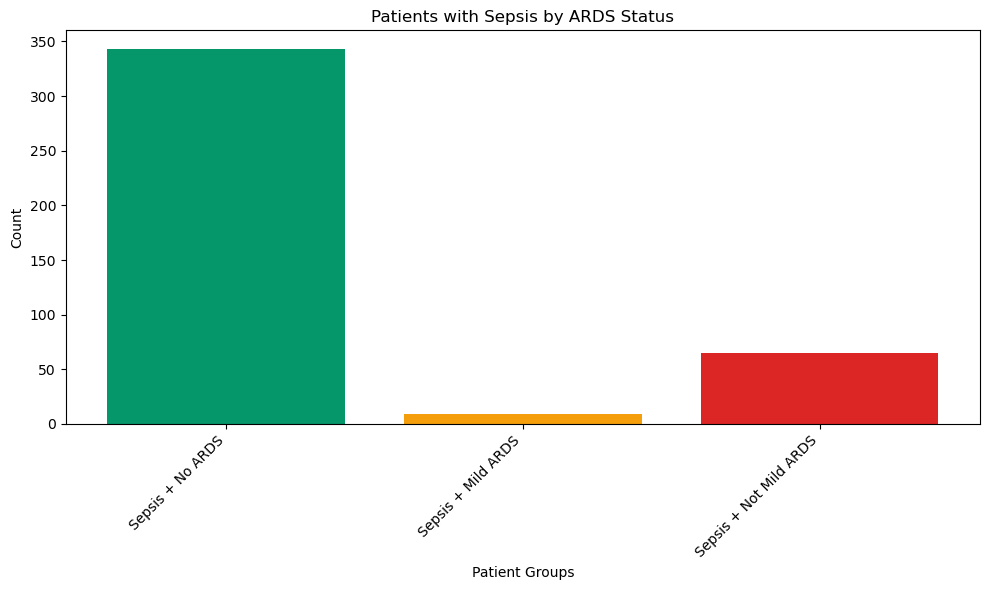

In [28]:
## Bar plot with patients having ARDS vs not having ARDS

# Create groups based on conditions
conditions = [
    (sepsis_data['ards'] == 0),
    (sepsis_data['ards'] == 1) & ((sepsis_data['ards_notmild'] == 0) | (sepsis_data['ards_mild'] == 1)),
    (sepsis_data['ards'] == 1) & ((sepsis_data['ards_notmild'] == 1) | (sepsis_data['ards_mild'] == 0))
]

labels = ['Sepsis + No ARDS', 'Sepsis + Mild ARDS', 'Sepsis + Not Mild ARDS']
group_counts = [sepsis_data[condition].shape[0] for condition in conditions]

# Create histogram
plt.figure(figsize=(10, 6))
plt.bar(labels, group_counts, color=[ARDS_COLORS["Not ARDS"], ARDS_COLORS["Mild ARDS"], ARDS_COLORS["Moderate/Severe ARDS"]])
plt.xlabel('Patient Groups')
plt.ylabel('Count')
plt.title('Patients with Sepsis by ARDS Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Female vs Male

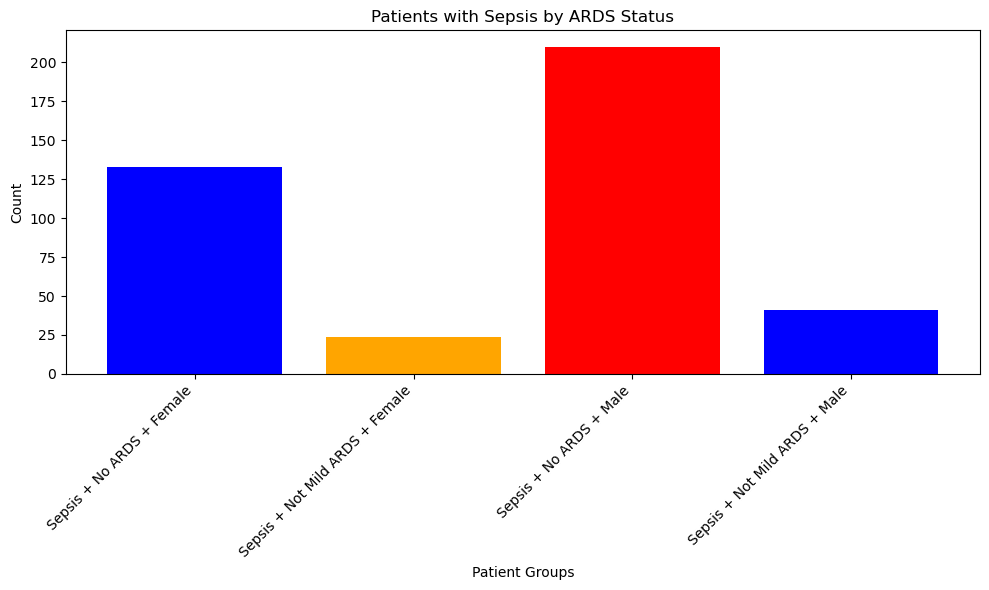

In [10]:
## Bar plot with patients having ARDS vs not having ARDS

# Create groups based on conditions
conditions = [
    (clean_data['Sepsis'] == 1) & (clean_data['ards'] == 0) & (clean_data['female'] == 1),
    (clean_data['Sepsis'] == 1) & (clean_data['ards'] == 1) & ((clean_data['ards_notmild'] == 1) | (clean_data['ards_mild'] == 0)) & (clean_data['female'] == 1), 
    (clean_data['Sepsis'] == 1) & (clean_data['ards'] == 0) & (clean_data['female'] == 0),
    (clean_data['Sepsis'] == 1) & (clean_data['ards'] == 1) & ((clean_data['ards_notmild'] == 1) | (clean_data['ards_mild'] == 0)) & (clean_data['female'] == 0), 
]

labels = ['Sepsis + No ARDS + Female', 'Sepsis + Not Mild ARDS + Female', 'Sepsis + No ARDS + Male', 'Sepsis + Not Mild ARDS + Male']
group_counts = [clean_data[condition].shape[0] for condition in conditions]

# Create histogram
plt.figure(figsize=(10, 6))
plt.bar(labels, group_counts, color=['blue', 'orange', 'red'])
plt.xlabel('Patient Groups')
plt.ylabel('Count')
plt.title('Patients with Sepsis by ARDS Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Age distribution by gender

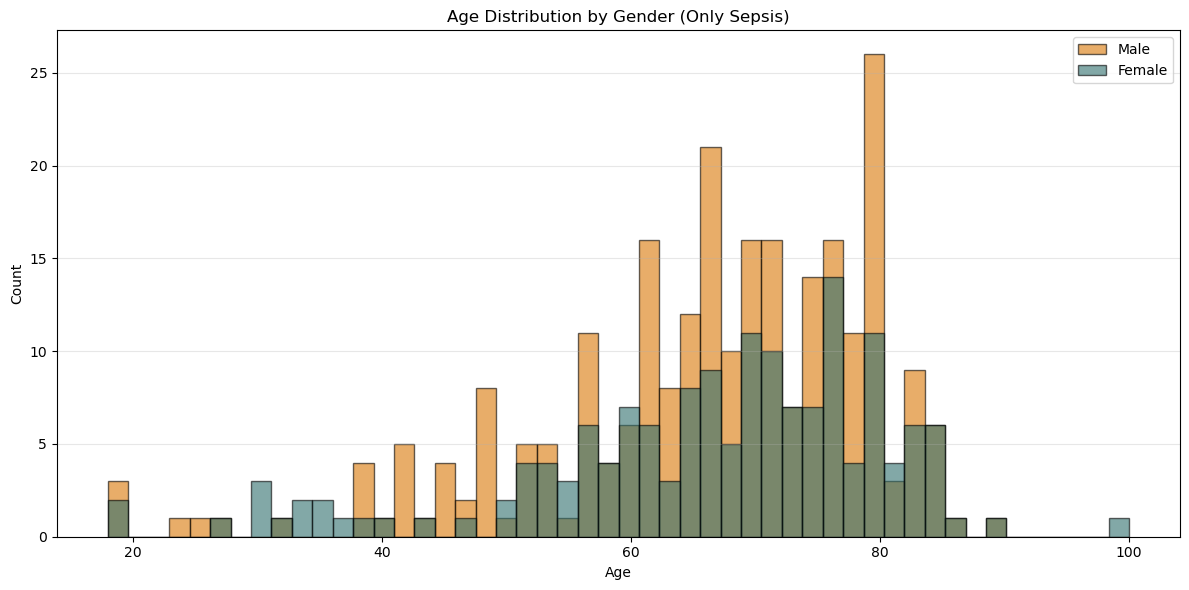

In [ ]:
# Create histogram with both female and male in same plot

plt.figure(figsize=(12, 6))

female_data = sepsis_data[(sepsis_data['female'] == 1)]
male_data = sepsis_data[(sepsis_data['female'] == 0)]

max_age = min(sepsis_data['age'].max(), 100)
min_age = max(sepsis_data['age'].min(), 0)

plt.hist(male_data['age'], bins=50, range=(min_age, max_age), color=COLORS[0], edgecolor='black', alpha=0.6, label='Male')
plt.hist(female_data['age'], bins=50, range=(min_age, max_age), color=COLORS[1], edgecolor='black', alpha=0.6, label='Female')

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution by Gender (Only Sepsis)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

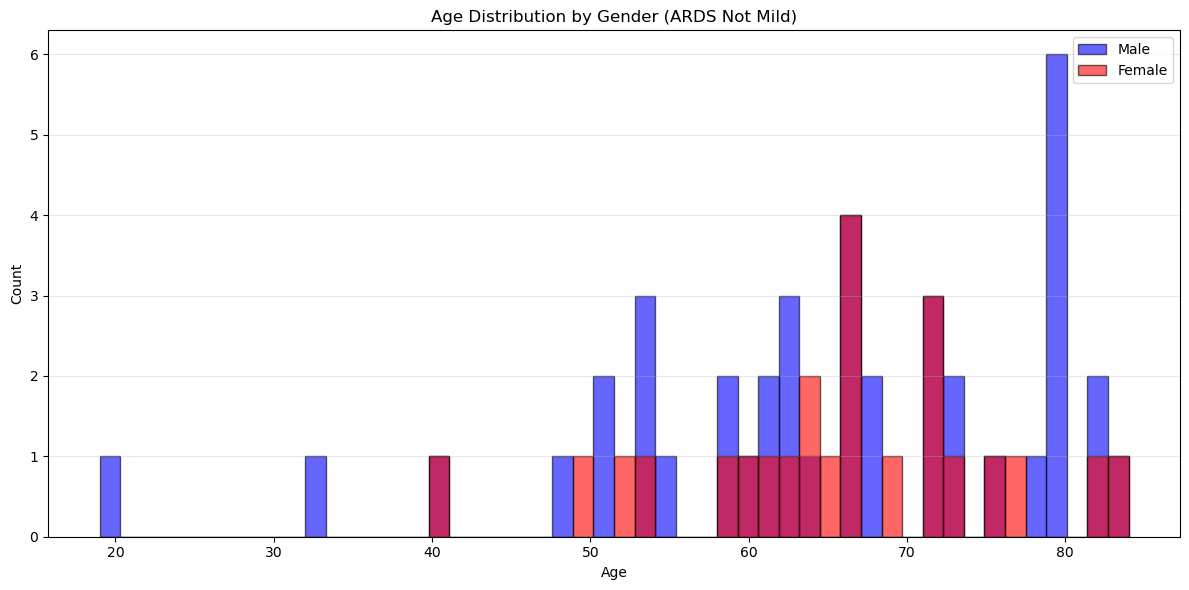

In [12]:
# Create histogram with both female and male in same plot

plt.figure(figsize=(12, 6))

female_data = ards_notmild_data[(ards_notmild_data['female'] == 1)]
male_data = ards_notmild_data[(ards_notmild_data['female'] == 0)]

max_age = min(ards_notmild_data['age'].max(), 100)
min_age = max(ards_notmild_data['age'].min(), 0)

plt.hist(male_data['age'], bins=50, range=(min_age, max_age), color='blue', edgecolor='black', alpha=0.6, label='Male')
plt.hist(female_data['age'], bins=50, range=(min_age, max_age), color='red', edgecolor='black', alpha=0.6, label='Female')

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution by Gender (ARDS Not Mild)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Protein (probe) histograms/density plot

#### Random features

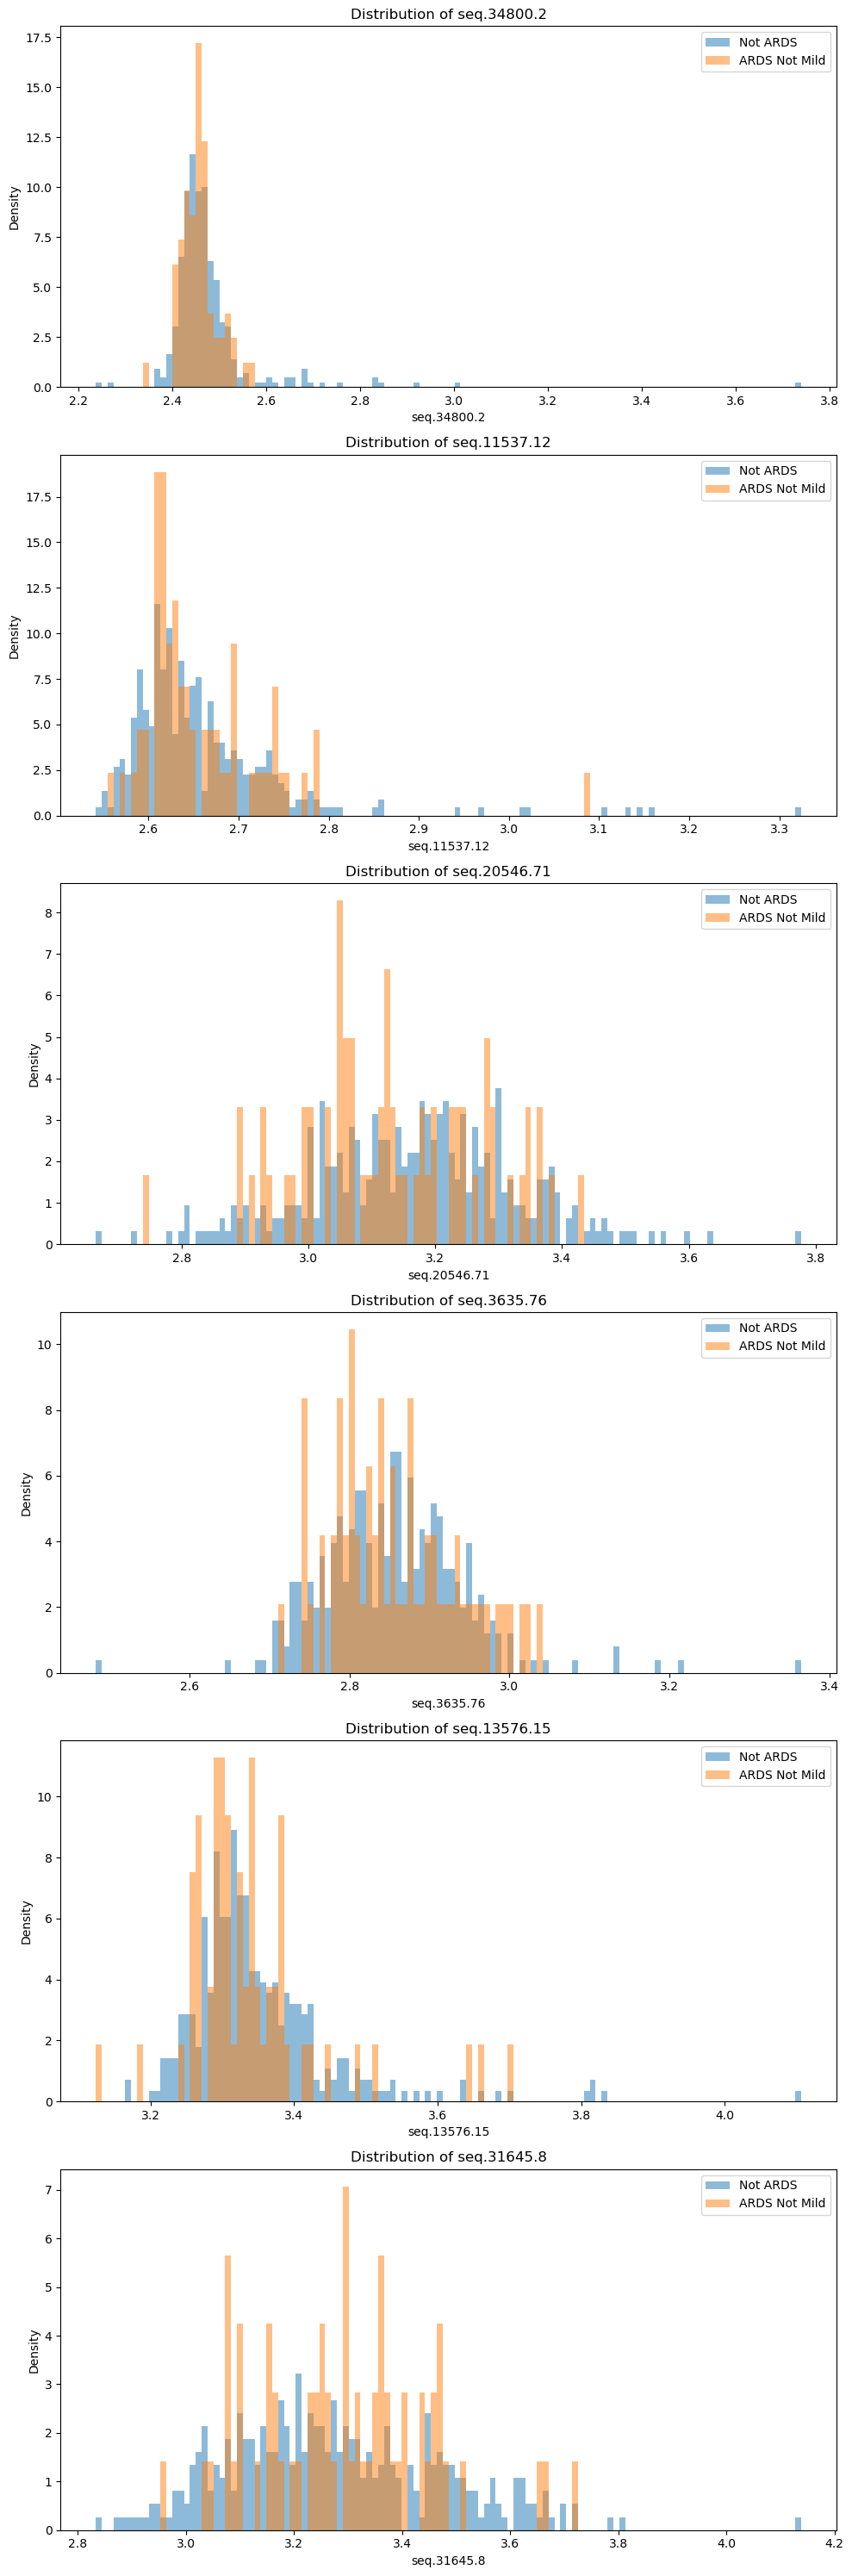

In [13]:
features = [c for c in clean_data.columns if c.startswith("seq.")]
assert len(features) > 0, "No seq.* columns found."

np.random.seed(0)
random_features = np.random.choice(features, size=min(6, len(features)), replace=False)

fig, axes = plt.subplots(len(random_features), 1, figsize=(10, 5 * len(random_features)))
if len(random_features) == 1:
    axes = np.array([axes])  # ensure 2D indexing

for i, feature in enumerate(random_features):
    # Raw distributions
    hist_range = (
        min(
            ards_notmild_data[feature].min(),
            sepsis_not_ards_data[feature].min()
        ),
        max(
            ards_notmild_data[feature].max(),
            sepsis_not_ards_data[feature].max()
        )
    )
    axes[i].hist(sepsis_not_ards_data[feature].dropna(), bins=120, alpha=0.5, label="Not ARDS", density=True, range=hist_range)
    axes[i].hist(ards_notmild_data[feature].dropna(), bins=120, alpha=0.5, label="ARDS Not Mild", density=True, range=hist_range)
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Density")
    axes[i].legend()


plt.tight_layout()
plt.show()

#### Features with biggest mean absolute difference

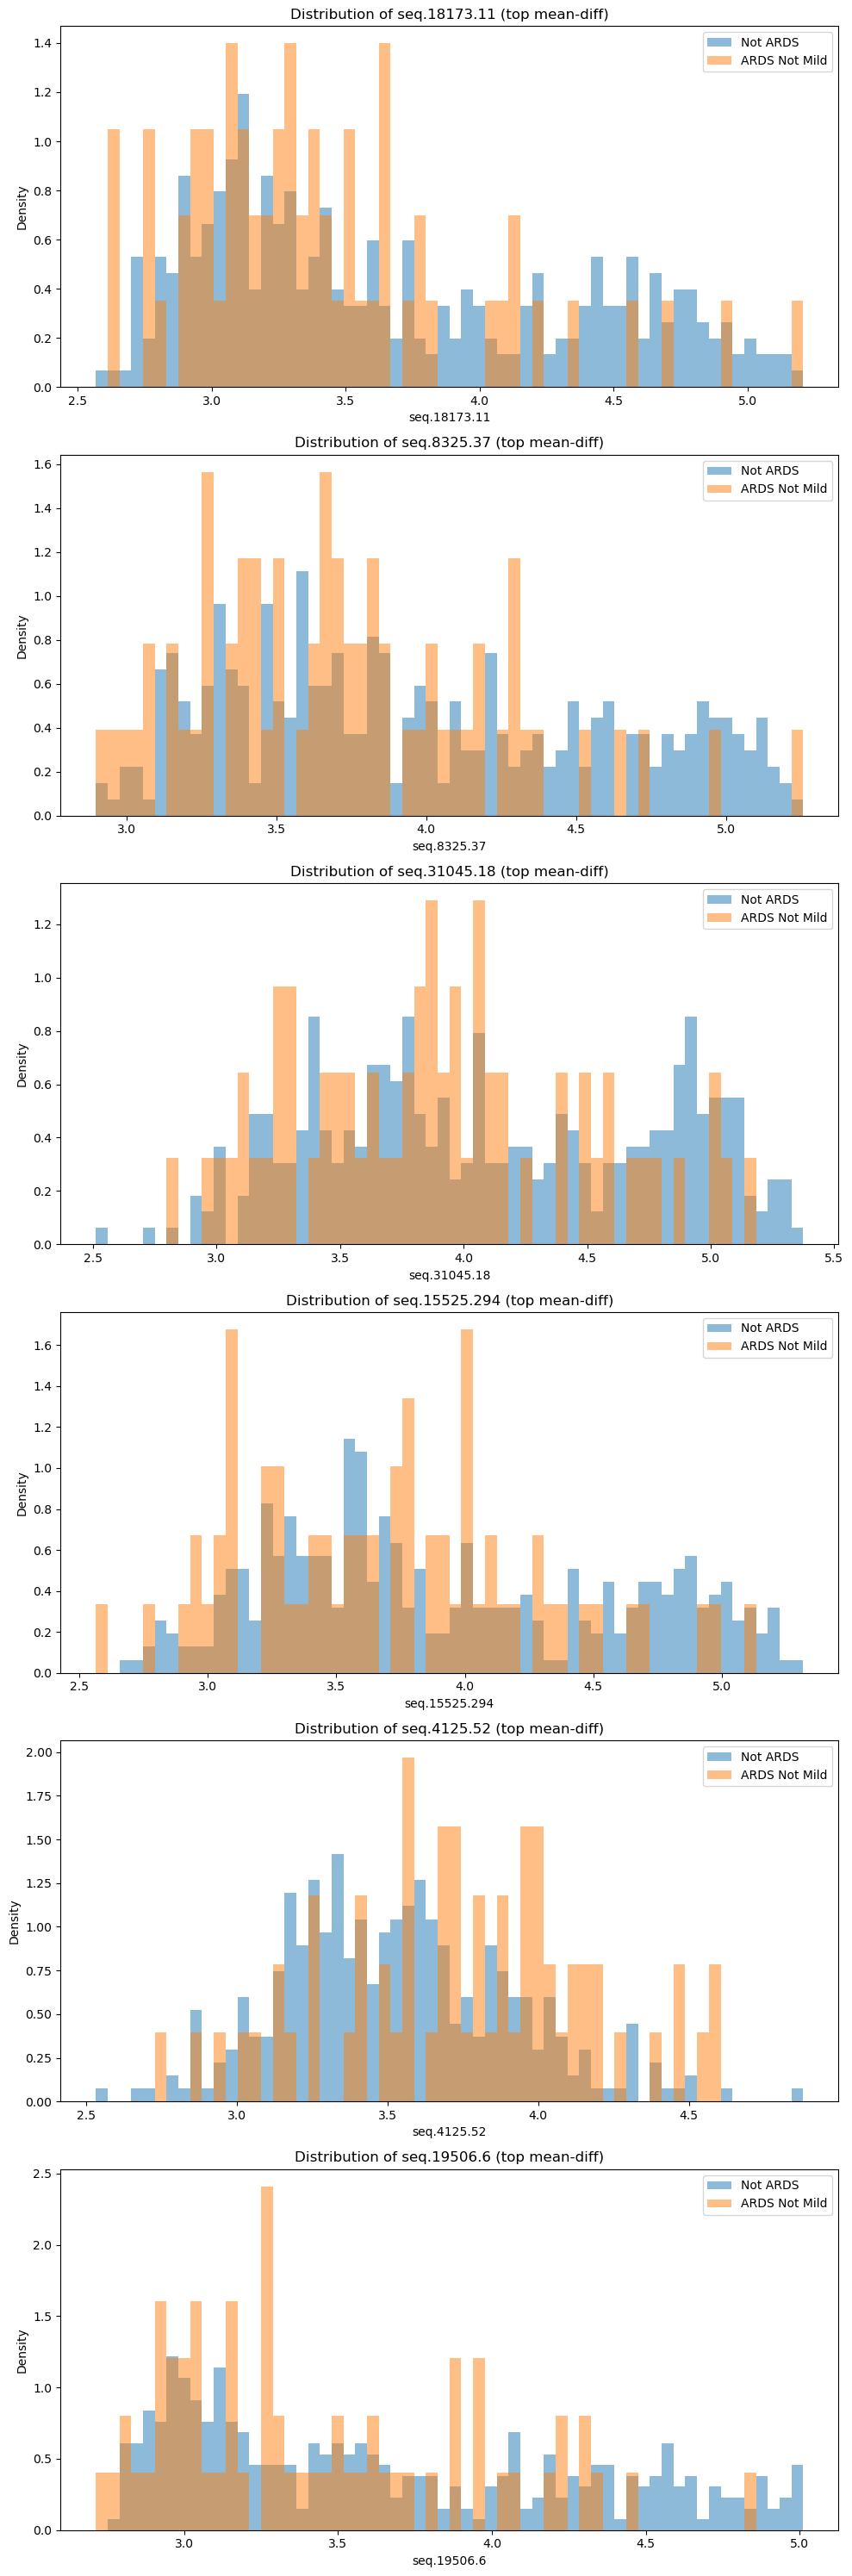

In [14]:
features = [c for c in clean_data.columns if c.startswith("seq.")]
assert len(features) > 0, "No seq.* columns found."

k = min(6, len(features))
means_not_ards = sepsis_not_ards_data[features].mean()
means_ards_notmild = ards_notmild_data[features].mean()
diff = (means_not_ards - means_ards_notmild).abs()
top_features = diff.sort_values(ascending=False).head(k).index.tolist()

fig, axes = plt.subplots(len(top_features), 1, figsize=(10, 5 * len(top_features)))
if len(top_features) == 1:
    axes = np.array([axes])

for i, feature in enumerate(top_features):
    # Raw distributions
    hist_min = min(sepsis_not_ards_data[feature].dropna().min(), ards_notmild_data[feature].dropna().min())
    hist_max = max(sepsis_not_ards_data[feature].dropna().max(), ards_notmild_data[feature].dropna().max())
    hist_range = (hist_min, hist_max)
    axes[i].hist(sepsis_not_ards_data[feature].dropna(), bins=60, alpha=0.5, label="Not ARDS", density=True, range=hist_range)
    axes[i].hist(ards_notmild_data[feature].dropna(), bins=60, alpha=0.5, label="ARDS Not Mild", density=True, range=hist_range)
    axes[i].set_title(f"Distribution of {feature} (top mean-diff)")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Density")
    axes[i].legend()

plt.tight_layout()
plt.show()


#### Features for male vs female

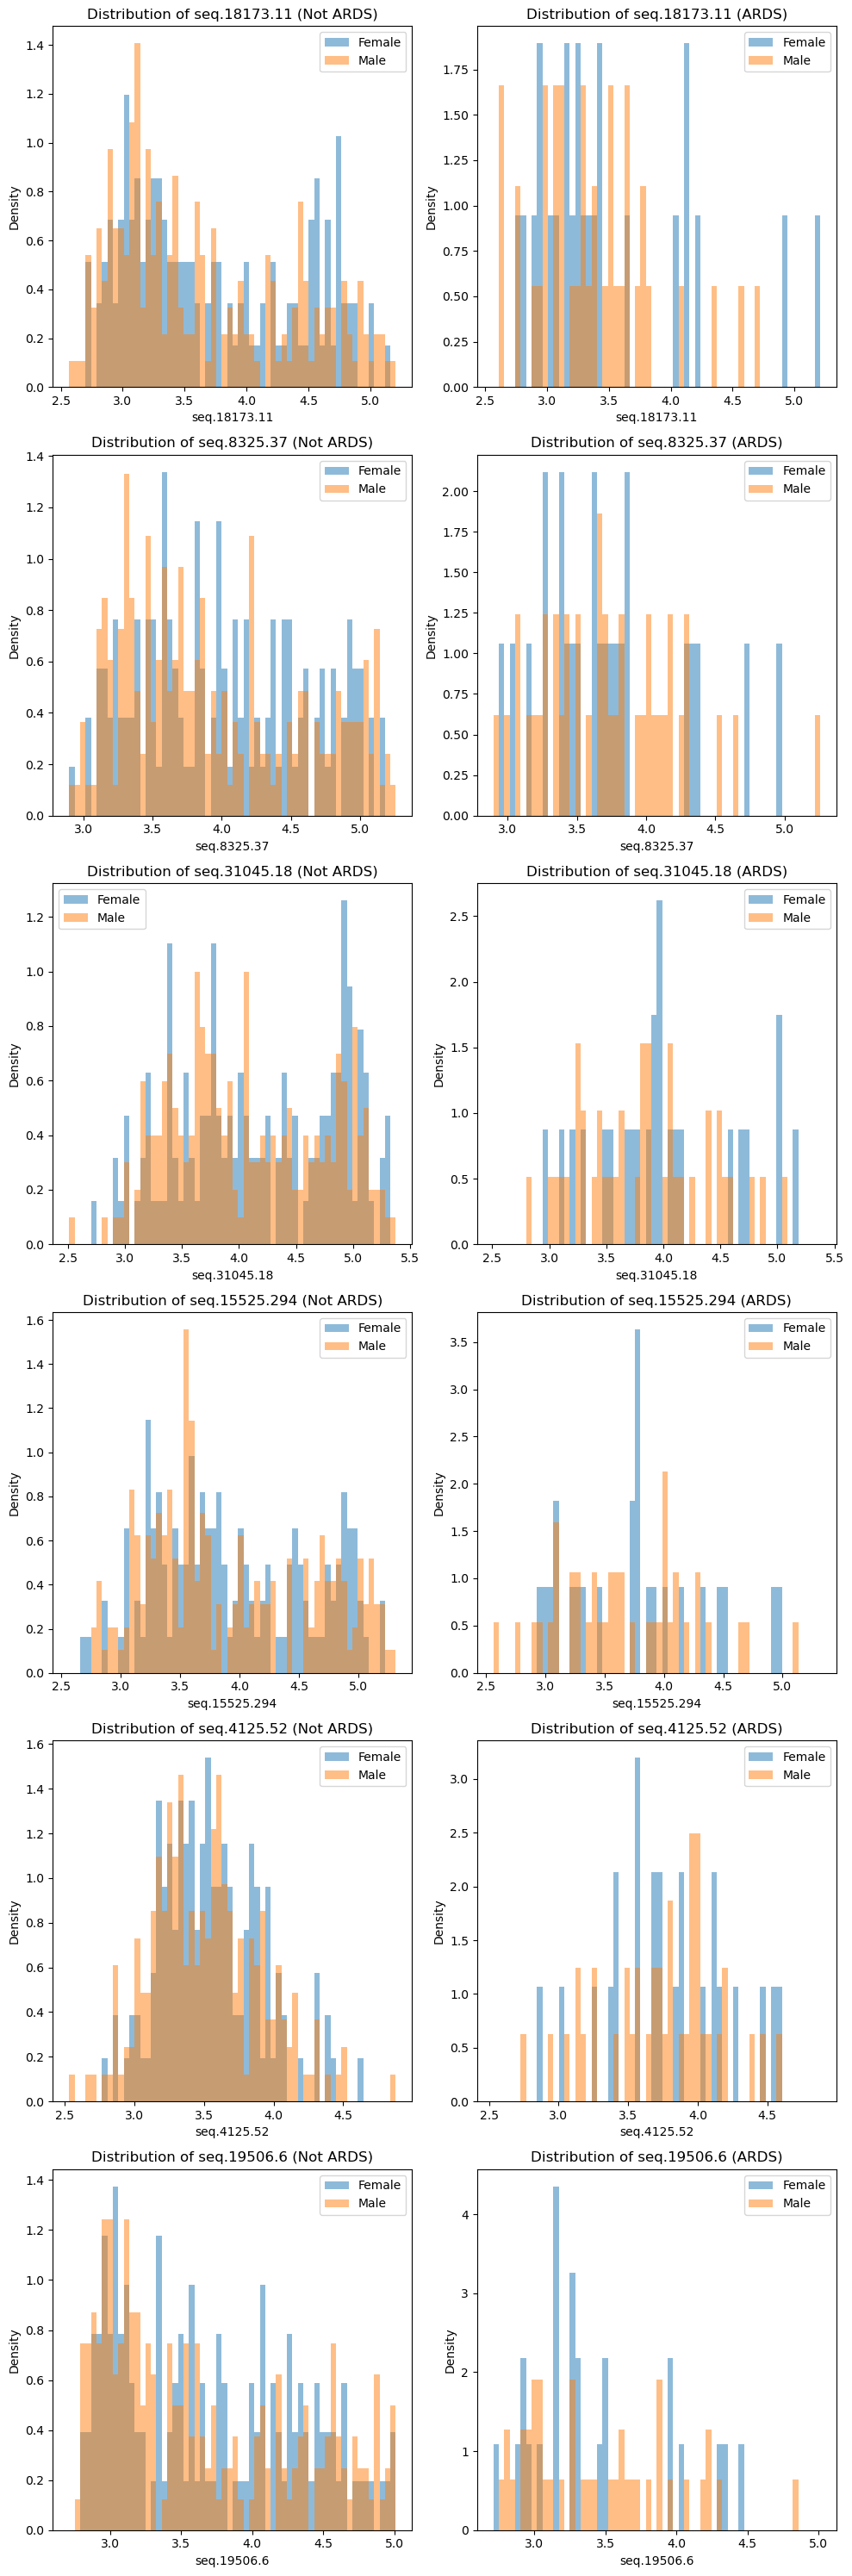

In [15]:
# Compare the top features between female and male, two subplots per feature, one for ards not mild one for not ards
fig, axes = plt.subplots(len(top_features), 2, figsize=(10, 5 * len(top_features)))
if len(top_features) == 1:
    axes = np.array([axes])

for i, feature in enumerate(top_features):
    female_ards = ards_notmild_data[ards_notmild_data['female'] == 1]
    male_ards = ards_notmild_data[ards_notmild_data['female'] == 0]
    female_notards = sepsis_not_ards_data[sepsis_not_ards_data['female'] == 1]
    male_notards = sepsis_not_ards_data[sepsis_not_ards_data['female'] == 0]

    # Raw distributions
    hist_min = min(sepsis_not_ards_data[feature].dropna().min(), ards_notmild_data[feature].dropna().min())
    hist_max = max(sepsis_not_ards_data[feature].dropna().max(), ards_notmild_data[feature].dropna().max())
    hist_range = (hist_min, hist_max)
    
    
    axes[i, 0].hist(female_notards[feature].dropna(), bins=60, alpha=0.5, label="Female", density=True, range=hist_range)
    axes[i, 0].hist(male_notards[feature].dropna(), bins=60, alpha=0.5, label="Male", density=True, range=hist_range)
    axes[i, 0].set_title(f"Distribution of {feature} (Not ARDS)")
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel("Density")
    axes[i, 0].legend()

    # ARDS distributions
    axes[i, 1].hist(female_ards[feature].dropna(), bins=60, alpha=0.5, label="Female", density=True, range=hist_range)
    axes[i, 1].hist(male_ards[feature].dropna(), bins=60, alpha=0.5, label="Male", density=True, range=hist_range)
    axes[i, 1].set_title(f"Distribution of {feature} (ARDS)")
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel("Density")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

### Cross-plot (Cross-feature scatter plot)

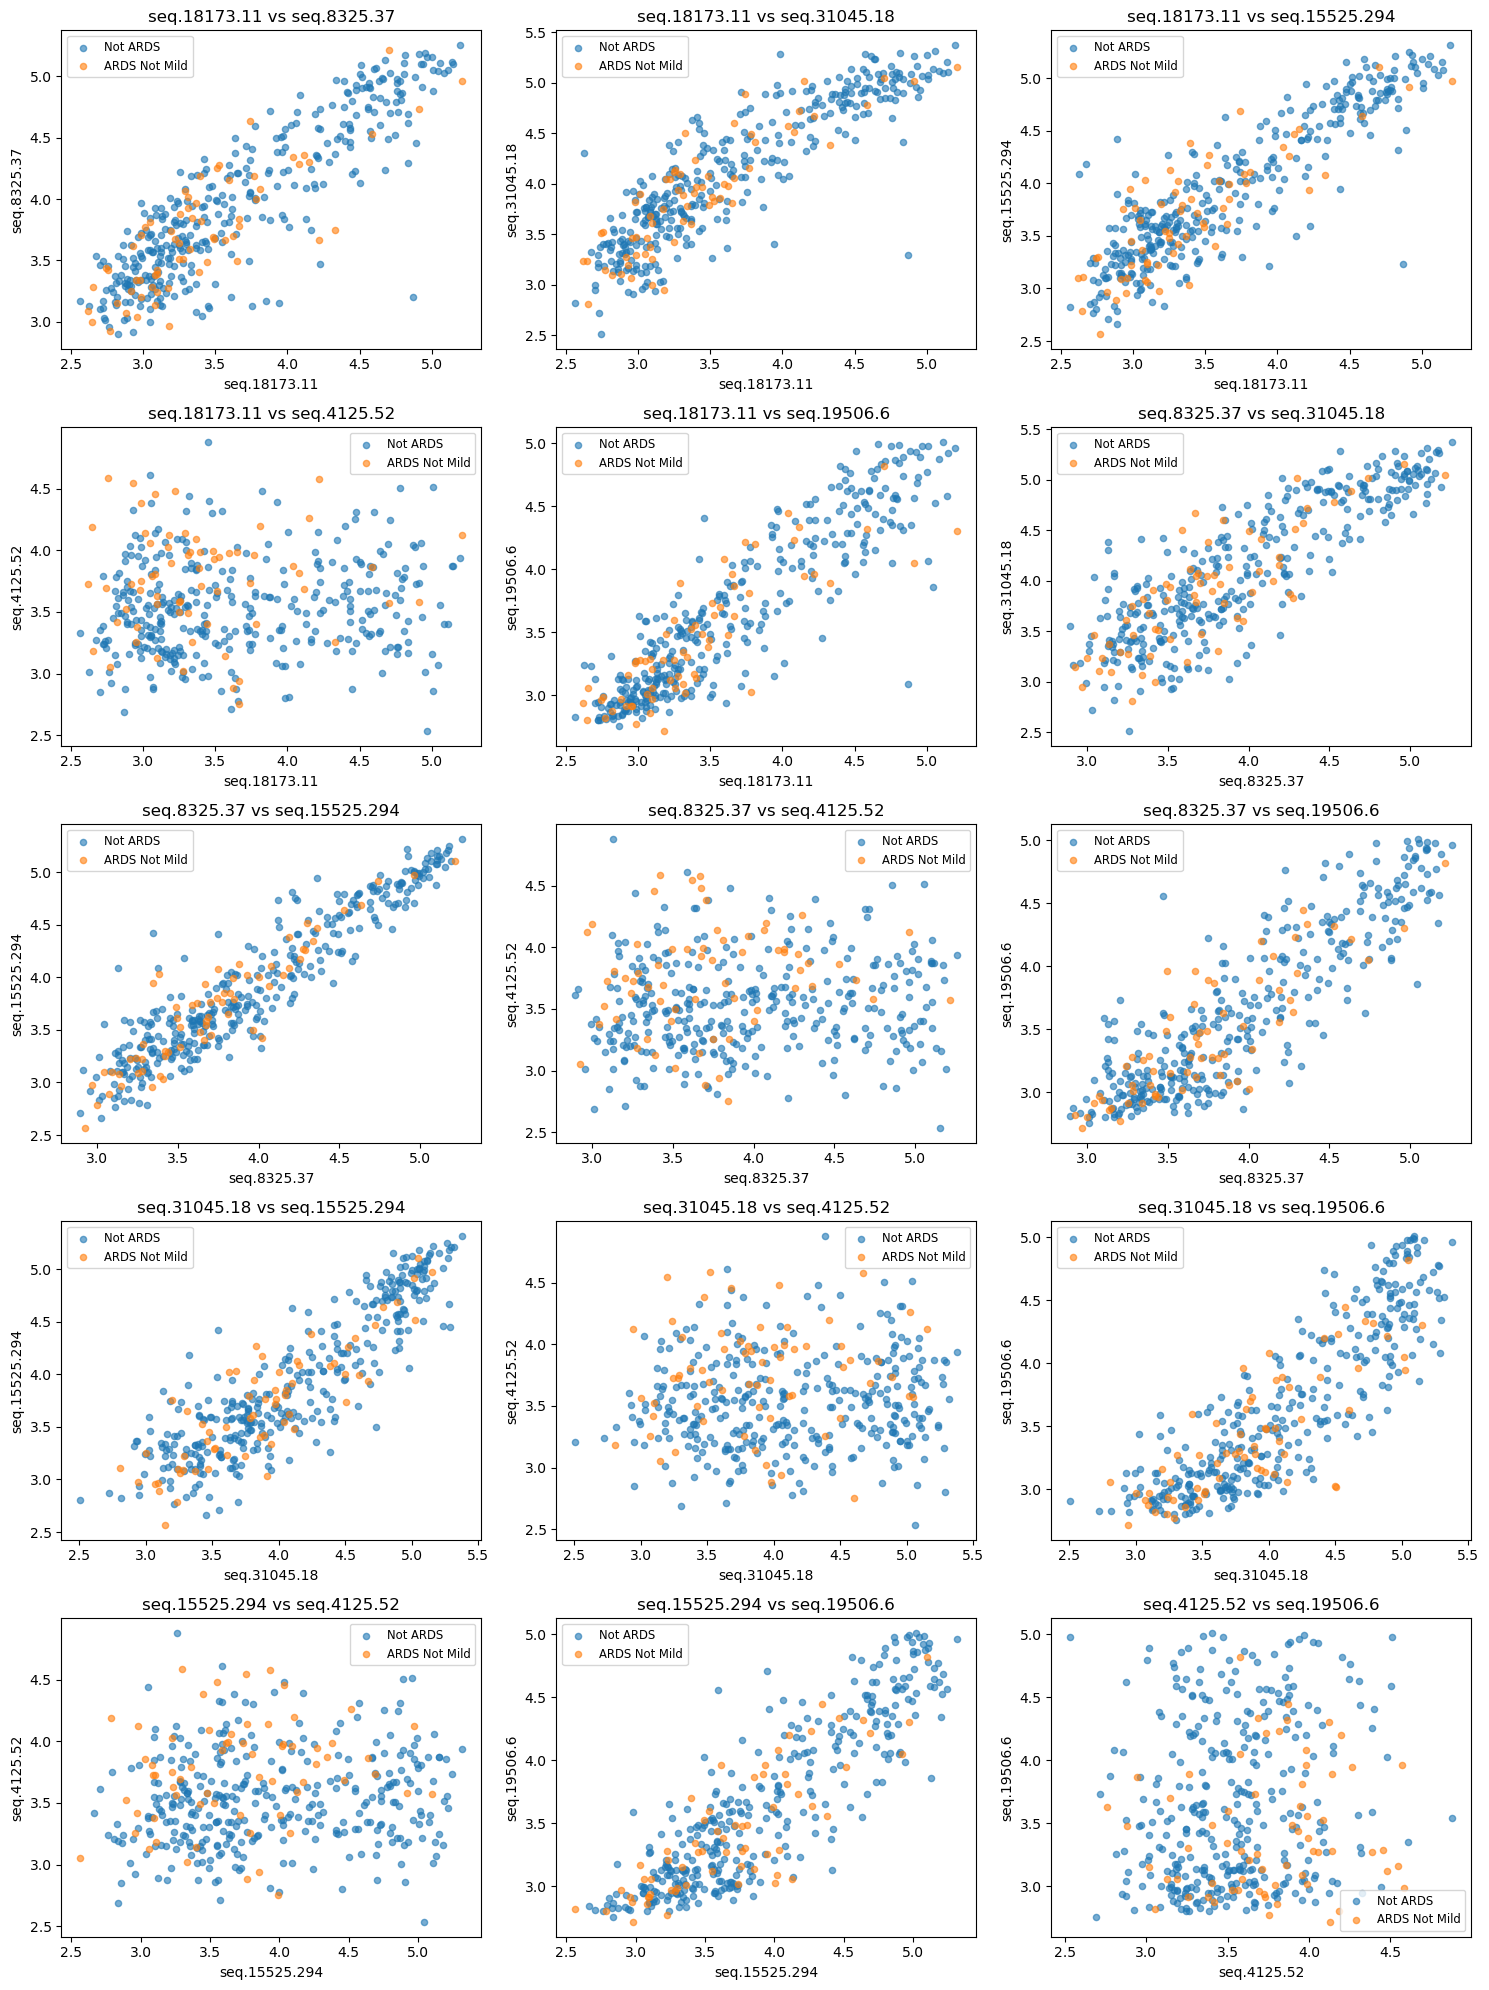

In [16]:
# Cross-feature scatter plots (pairs from top_features)
import itertools
features = top_features if 'top_features' in globals() else [c for c in clean_data.columns if c.startswith("seq.")][:6]
pairs = list(itertools.combinations(features, 2))
# limit number of panels to keep layout reasonable
pairs = pairs[:15]
n = len(pairs)
ncols = 3
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
for idx, (f1, f2) in enumerate(pairs):
    r, c = divmod(idx, ncols)
    ax = axes[r][c]
    df1 = sepsis_not_ards_data[[f1, f2]].dropna().assign(group='Not ARDS')
    df2 = ards_notmild_data[[f1, f2]].dropna().assign(group='ARDS Not Mild')
    dfp = pd.concat([df1, df2], ignore_index=True)
    ax.scatter(dfp.loc[dfp['group']=='Not ARDS', f1], dfp.loc[dfp['group']=='Not ARDS', f2],
               s=20, alpha=0.6, label='Not ARDS', color='tab:blue')
    ax.scatter(dfp.loc[dfp['group']=='ARDS Not Mild', f1], dfp.loc[dfp['group']=='ARDS Not Mild', f2],
               s=20, alpha=0.6, label='ARDS Not Mild', color='tab:orange')
    ax.set_xlabel(f1); ax.set_ylabel(f2)
    ax.set_title(f"{f1} vs {f2}")
    ax.legend(fontsize='small')
# hide any unused axes
for i in range(n, nrows * ncols):
    axes[i // ncols][i % ncols].axis('off')
plt.tight_layout()
plt.show()


### Protein-protein correlation

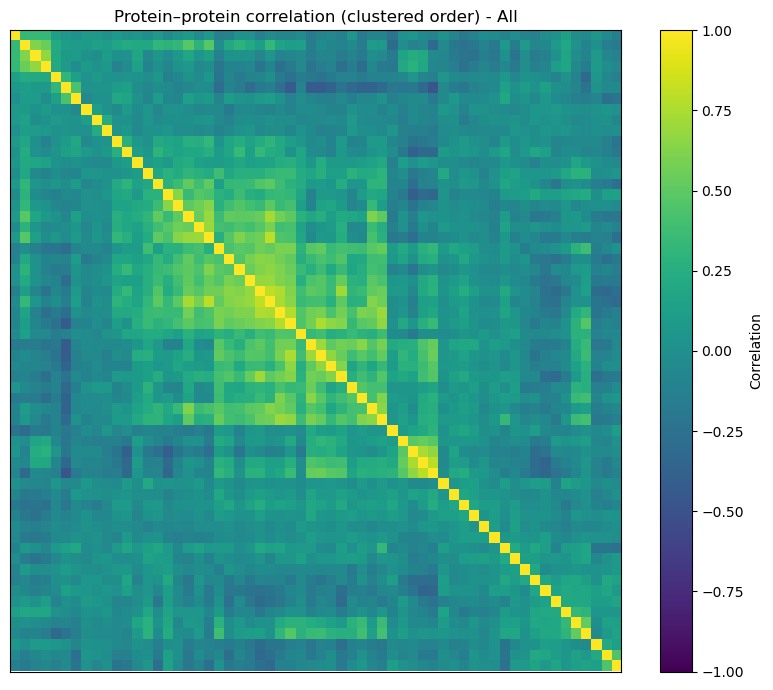

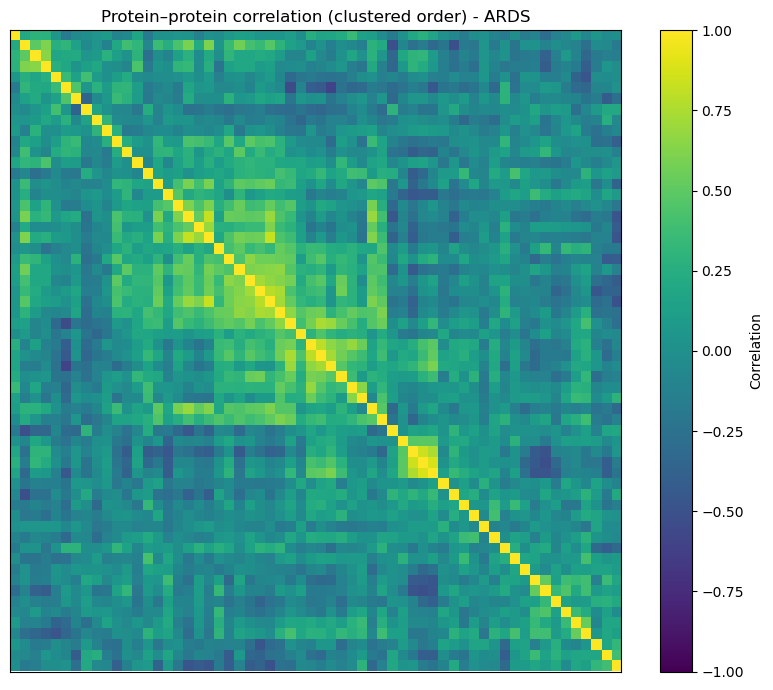

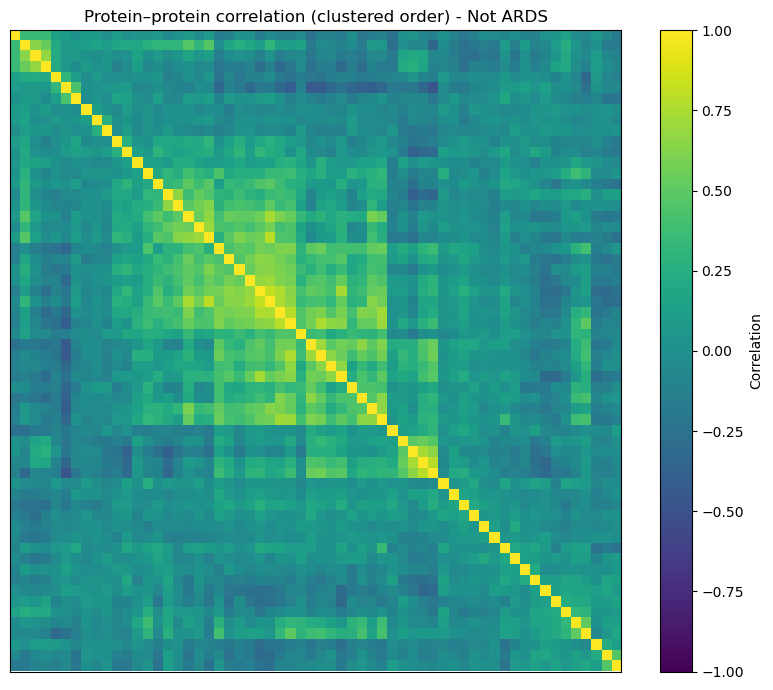

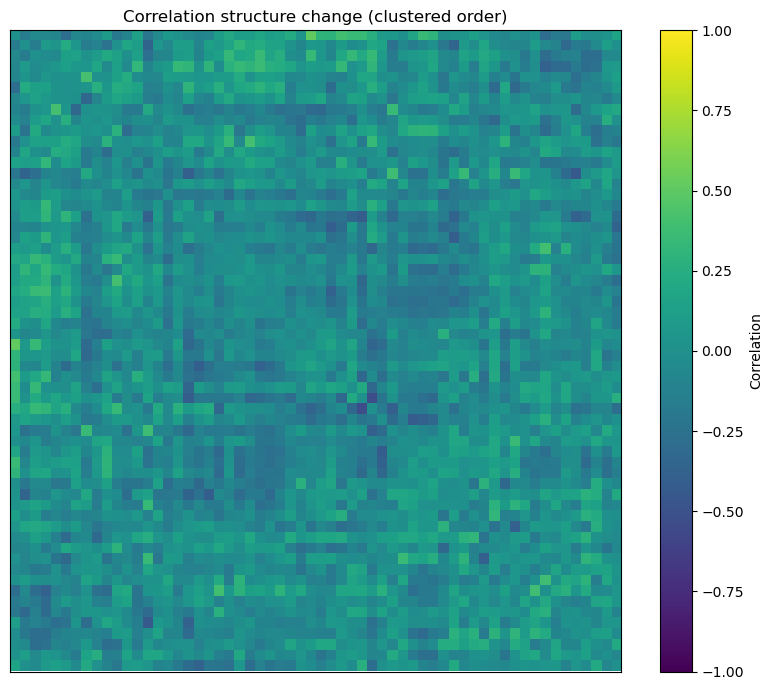

In [17]:
features = [c for c in clean_data.columns if c.startswith("seq.")]
assert len(features) > 0, "No seq.* columns found."

# Use a subset to keep it fast/visible
#np.random.seed(1)
corr_feats = np.random.choice(features, size=min(60, len(features)), replace=False)

def corr_matrix(df, feats):
    mat = df[feats].dropna().astype(float).copy()
    mat = mat.apply(lambda c: c.fillna(c.median()), axis=0)
    return mat.corr()

corr_all = corr_matrix(sepsis_data, corr_feats)
corr_ards = corr_matrix(ards_notmild_data, corr_feats)
corr_not = corr_matrix(sepsis_not_ards_data, corr_feats)

# Hierarchical clustering order using correlation distance
# distance = 1 - corr (make sure it's finite)
C = corr_all.to_numpy()
C = np.nan_to_num(C, nan=0.0)
D = 1 - C
np.fill_diagonal(D, 0.0)
Z = linkage(squareform(D, checks=False), method="average")
order = dendrogram(Z, no_plot=True)["leaves"]
ordered_feats = [corr_feats[i] for i in order]

def plot_heatmap(corr_df, title):
    plt.figure(figsize=(8, 7))
    M = corr_df.loc[ordered_feats, ordered_feats].to_numpy()
    plt.imshow(M, aspect="auto", vmin=-1, vmax=1)
    plt.colorbar(label="Correlation")
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

plot_heatmap(corr_all, "Protein–protein correlation (clustered order) - All")
plot_heatmap(corr_ards, "Protein–protein correlation (clustered order) - ARDS")
plot_heatmap(corr_not, "Protein–protein correlation (clustered order) - Not ARDS")

# Correlation difference heatmap
corr_diff = corr_ards - corr_not
plot_heatmap(corr_diff, "Correlation structure change (clustered order)")
#plt.figure(figsize=(8, 7))
#M = corr_diff.loc[ordered_feats, ordered_feats].to_numpy()
#plt.imshow(M, aspect="auto")
#plt.colorbar(label="Corr(ARDS) - Corr(Not ARDS)")
#plt.title("Correlation structure change (clustered order)")
#plt.xticks([])
#plt.yticks([])
#plt.tight_layout()
#plt.show()